## Paper Reading Analysis - Code Implementation
### Model 8 Training, Hyperparameter Search and Evaluation
### Jonathan Alcineus

In [1]:
# These handle the file locations and importing the dataframe from the saved datafile from the authors files
import os
import pandas as pd


# These handle the image processing, editing, or displaying that needs to be performed
import cv2 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import skimage

# These handle training the convolutional neural network (CNN) model
import tensorflow as tf
import keras
import numpy as np
import sklearn
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
import time

import copy

2025-09-02 18:35:06.318174: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 18:35:06.339106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756838106.364037   34810 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756838106.375694   34810 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756838106.396134   34810 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# This changes the home directory
home_directory = os.path.expanduser("~")
os.chdir(home_directory)

# Then goes to the folder where the data lies
os.chdir('DNNorDermatologist')

# Ensures that we are in the correct folder
print(os.getcwd())

/teamspace/studios/this_studio/DNNorDermatologist


In [3]:
# Begin to build the classifier and the ranges for each model to find the optimal parameters, or searching through hyperparameters
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

space = [Real(1e-6, 0.01, "log-uniform", name='learning_rate'),
          Real(0.1, 0.8, name='dropout'),
          Real(0.8, 1.0, name='momentum'),
          Real(0.9, 1.0, name='beta_1'),
          Real(0.99, 1.0, name='beta_2'),
          Integer(low=5,high=20, name = 'epochs'),
          Integer(low=50, high=225, name='num_dense_nodes'),
          Categorical(categories=['SGD', 'Adam'],
                             name='optimizer_type')
          ]

In [4]:

# The first part to implenment is the creation of random models
if not os.path.isdir('suite_of_models'):
    os.mkdir('suite_of_models')

def make_a_model(learning_rate, dropout, momentum, beta_1, beta_2, num_dense_nodes, optimizer_type):
    # Like in the paper the base model for the image classifcation will be imagenet
    base_model = InceptionV3(weights='imagenet',input_shape=(224, 224, 3), include_top=False)

    # Fine tune the model with extra dense layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_dense_nodes, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(rate=dropout)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Selects a type of model optimizer
    if optimizer_type == "Adam":
        optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    elif optimizer_type == "SGD":
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(loss='binary_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])
    return model

In [5]:
# Start off with basic parameters and the batch size for the models
batch_size = 16
best_accuracy = {} 
for seed in range(15):
  best_accuracy[seed] = 0.0

In [6]:
# Training on seed 0 for this cell

seed = 7

print('We are currently training on seed:', seed) 
# for each iteration of the hyperparameter search, return a set of parameters
# and feed them into the relevant parts
# run training of the model for this seed, save with seed num
X_train = np.load(f'paper_reading_small_data/trial_{seed}_X_train.npy', allow_pickle=True)
y_train = np.load(f'paper_reading_small_data/trial_{seed}_y_train.npy', allow_pickle=True)
X_test = np.load(f'paper_reading_small_data/trial_{seed}_X_test.npy', allow_pickle=True)
y_test = np.load(f'paper_reading_small_data/trial_{seed}_y_test.npy', allow_pickle=True)

path_best_model = 'inception_saved_trial_{}.keras'.format(seed)
  
@use_named_args(dimensions=space)
def fitness(learning_rate, dropout, momentum, beta_1, beta_2,
              num_dense_nodes, optimizer_type, epochs):

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_nodes:', num_dense_nodes)
    print('dropout:', dropout)
    print('optimizer_type:', optimizer_type)
    print('epochs:', epochs)

    # Create the neural network with these hyper-parameters.
    model = make_a_model(learning_rate=learning_rate, 
                         dropout=dropout, 
                         momentum=momentum, 
                         beta_1=beta_1, beta_2=beta_2,
                         num_dense_nodes=num_dense_nodes, 
                         optimizer_type=optimizer_type)

    # Use Keras to train the model.
    history = model.fit(x=X_train,
                          y=y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data= (X_test,y_test))

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]
    # auc_val = history.history['val_auc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    if accuracy > best_accuracy[seed]:
      # Save the new model to harddisk in the recommended Keras format
      model_path = os.path.join('DataSplitted', path_best_model)
      model.save(model_path)
    

      # Update the classification accuracy.
      best_accuracy[seed] = accuracy
      # best_auc = auc_val
          

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    import gc

    keras.backend.clear_session()
    gc.collect()

    try:
      tf.config.experimental.reset_memory_stats("GPU:0")
    except:
      pass  # in case older TF version
    return -accuracy

  
#This conducts the hyperparameter search over each data split for details see: https://scikit-optimize.github.io/#skopt.gp_minimize
search_result = gp_minimize(func=fitness,
                            dimensions=space,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15,
			    n_random_starts = 5,
                            verbose = True)
print('Seed: ',seed)
print("BEST ACCURACY: ", best_accuracy)
print('hyper_params ', search_result.x)

del X_train, y_train, X_test, y_test 

import gc

keras.backend.clear_session()
gc.collect()

We are currently training on seed: 7


Iteration No: 1 started. Evaluating function at random point.
learning rate: 1.8e-03
num_dense_nodes: 159
dropout: 0.21012348317088542
optimizer_type: SGD
epochs: 9


I0000 00:00:1756006060.123016  168605 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13949 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Epoch 1/9


I0000 00:00:1756006084.594323  169115 service.cc:152] XLA service 0x7fa7f40147f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756006084.594354  169115 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-24 03:28:05.473732: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756006088.498817  169115 cuda_dnn.cc:529] Loaded cuDNN version 91200
2025-08-24 03:28:16.563847: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-24 03:28:16.711698: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investiga

 1/52 ━━━━━━━━━━━━━━━━━━━━ 44:42 53s/step - accuracy: 0.5000 - loss: 0.7986

I0000 00:00:1756006116.248165  169115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6607 - loss: 0.6268

2025-08-24 03:28:51.734431: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-24 03:28:51.881725: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-24 03:28:52.192693: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-24 03:28:52.335570: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


52/52 ━━━━━━━━━━━━━━━━━━━━ 99s 909ms/step - accuracy: 0.7452 - loss: 0.5249 - val_accuracy: 0.5338 - val_loss: 0.9958
Epoch 2/9
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.8708 - loss: 0.3105 - val_accuracy: 0.6860 - val_loss: 0.7034
Epoch 3/9
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9203 - loss: 0.2150 - val_accuracy: 0.7452 - val_loss: 0.5141
Epoch 4/9
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9300 - loss: 0.1797 - val_accuracy: 0.7850 - val_loss: 0.4782
Epoch 5/9
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9505 - loss: 0.1356 - val_accuracy: 0.8080 - val_loss: 0.4487
Epoch 6/9
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9710 - loss: 0.0873 - val_accuracy: 0.8514 - val_loss: 0.4122
Epoch 7/9
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9758 - loss: 0.0855 - val_accuracy: 0.8442 - val_loss: 0.4221
Epoch 8/9
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9783 - loss: 0.0631 - val_accuracy: 0.8430 - val_loss:

0

In [3]:
# GradCAM and Kernel SHAP Experiments
os.chdir(home_directory)
os.chdir('paper-reading-analysis')

# Library with the methods that I needed
import gradcam_shap
import scipy

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.chdir(home_directory)
os.chdir('DNNorDermatologist')
os.chdir('DataSplitted')
seed = 7
model = load_model(f'inception_saved_trial_{seed}.keras')

I0000 00:00:1756838125.866491   34810 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13949 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [5]:
import collections
import collections.abc
collections.Iterable = collections.abc.Iterable

from vis.utils import utils
from keras import layers, activations

#Assorted modifications for model compatibility with gradCAM
gmodel = copy.deepcopy(model)

print(gmodel.layers)

layer_idx = utils.find_layer_idx(gmodel,'dense_1')

#swap with softmax with linear classifier for the reasons mentioned above
gmodel.layers[layer_idx].activation = activations.linear
gmodel = utils.apply_modifications(gmodel)

[<InputLayer name=input_layer, built=True>, <Conv2D name=conv2d, built=True>, <BatchNormalization name=batch_normalization, built=True>, <Activation name=activation, built=True>, <Conv2D name=conv2d_1, built=True>, <BatchNormalization name=batch_normalization_1, built=True>, <Activation name=activation_1, built=True>, <Conv2D name=conv2d_2, built=True>, <BatchNormalization name=batch_normalization_2, built=True>, <Activation name=activation_2, built=True>, <MaxPooling2D name=max_pooling2d, built=True>, <Conv2D name=conv2d_3, built=True>, <BatchNormalization name=batch_normalization_3, built=True>, <Activation name=activation_3, built=True>, <Conv2D name=conv2d_4, built=True>, <BatchNormalization name=batch_normalization_4, built=True>, <Activation name=activation_4, built=True>, <MaxPooling2D name=max_pooling2d_1, built=True>, <Conv2D name=conv2d_8, built=True>, <BatchNormalization name=batch_normalization_8, built=True>, <Activation name=activation_8, built=True>, <Conv2D name=conv2d_

In [6]:
os.chdir(home_directory)
os.chdir('paper-reading-analysis')
%run gradcam_shap.py

In [7]:
os.chdir(home_directory)
os.chdir('DNNorDermatologist')

# Get the test dataset of 400 - 200 nevi and 200 melanoma
test_df = pd.read_pickle('NvAndMelNoDuplicatesFullSizeTestSet.zip')

# Change the idx column to be '0' where the diagnosis of the lesion was
# nevi, and '1' when the diagnosis is diagnosis
test_df['idx'] = np.where(test_df['id'] == 'mel', 1 , 0)

# Save a new table 'features' to be test_df, without the idx column
features=test_df.drop(columns=['idx'], axis = 1)
# Create a new table with just the correct diagnosis (0 for melanoma (or nevi), 1 for nevi (or melanoma))
target=test_df['idx']

# Change features to be a numpy array of image pixel data ((R, G, B))
features = np.asarray(features['image'].tolist())

# I want to resize the images 
features = np.array([cv2.resize(image, (224, 224)) for image in features])

# Normalise this data in an alternate table to be values from 0 ... 1
# e.g. 255 -> 1, 0 --> 0
# Normalises for original prediction and evaluation of model, the SHAP funciton below requires non normalised data
# TODO: Standarise this so SHAP takes normalised

features2 = features / 255

# Convert the data to one-hot encoding
target_cat = to_categorical(target, num_classes = 2)

# Get predictions for image data
# e.g.
# Index 0 : [0.9222, 0.0778]
# Index 1 : [0.4500, 0.5500]
# etc..
# This represents likelihood of melanoma and nevi respectively (according to the model)
y_pred = model.predict(features2, verbose=1)
y_pred = [[value[0], 1-value[0]] for value in y_pred]

print(y_pred)

# Create a new dataframe with entries for each element of the test set
# Include an ID, diagnosis, and % likelihoods for each diagnosis from the model
df = pd.DataFrame(columns=['ID', 'Dx', '% Mel', '% Nev'],index=[i for i in range(400)])
df['ID'] = df.index

# Create dictionaries to contain actual diagnosis and probabilities from the model
dx_d = {}
Pmel = {}
Pnev = {}
# Take the actual diagnoses from where we retrieved them earlier
y_test_cat = target_cat

# For each element in the test set:
for ind in range(400):
    # Append the diagnosis and predictions to their respective dictionaries
    if y_test_cat[ind][1] == 1.0:
        diagnosis = 'Melanoma'
    elif y_test_cat[ind][0] == 1.0:
        diagnosis = 'Nevus'
    dx_d[ind] = diagnosis
    Pmel[ind] = y_pred[ind][0]
    Pnev[ind] = y_pred[ind][1]
    
# Take the above dictionaries and insert them into the data frame
df['Dx'] = df['ID'].map(dx_d)
df['% Mel'] = df['ID'].map(Pmel)
df['% Nev'] = df['ID'].map(Pnev)

# Change the prediction likelihoods to be floats 
df = df.astype({"% Mel": float, "% Nev": float})

#df = df.iloc[id_list]

# Print the first 5 entries in the data frame
print('Unseen set') 
print(df)

I0000 00:00:1756838160.291340   35628 service.cc:152] XLA service 0x7f9c48057750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756838160.291368   35628 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-09-02 18:36:00.407789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756838161.563704   35628 cuda_dnn.cc:529] Loaded cuDNN version 91200


 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

I0000 00:00:1756838167.336137   35628 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 753ms/step
[[np.float32(0.9999999), np.float32(1.1920929e-07)], [np.float32(0.99647754), np.float32(0.0035224557)], [np.float32(0.9983309), np.float32(0.0016691089)], [np.float32(0.99986017), np.float32(0.0001398325)], [np.float32(0.9938554), np.float32(0.006144583)], [np.float32(1.0), np.float32(0.0)], [np.float32(0.9988477), np.float32(0.001152277)], [np.float32(0.9998059), np.float32(0.00019407272)], [np.float32(0.99999905), np.float32(9.536743e-07)], [np.float32(0.692026), np.float32(0.30797398)], [np.float32(1.0), np.float32(0.0)], [np.float32(0.95504534), np.float32(0.044954658)], [np.float32(0.99999976), np.float32(2.3841858e-07)], [np.float32(0.9987678), np.float32(0.0012322068)], [np.float32(0.9923461), np.float32(0.007653892)], [np.float32(0.98095864), np.float32(0.01904136)], [np.float32(0.9999032), np.float32(9.679794e-05)], [np.float32(0.9951454), np.float32(0.0048546195)], [np.float32(0.99954695), np.float32(0.0004530549)], [np.float32(0.999

In [8]:
os.chdir('..')
os.chdir('paper-reading-analysis')

# I want examine the results, so I will just save them
df.to_csv(f'predictions_model_{seed}.csv')

### Batching a random sample of 10 images for the GradCAM and the SHAP Images for Comparing Against Models with Seeds 8 and 10

In [9]:
# Create a list of 10 random images 
np.random.seed(123)

sample_images = list(np.random.choice(list(range(400)), 10, replace=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step


100%|██████████| 1/1 [00:30<00:00, 30.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.06901401
  0.         -0.09848478  0.          0.         -0.10321833  0.
  0.         -0.10990067  0.          0.          0.          0.
 -0.10285484  0.          0.          0.          0.          0.
  0.          0.          0.         -0.09789006  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.02376408  0.
  0.          0.03857144  0.02647483  0.          0.          0.
  0.         -0.08527651  0.03218583  0.          0.          0.
  0.02966306  0.          0.          0.         -0.07706095  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.         -0.09312844 -0.09315515  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.08042107  0.
  0.          0.          0.          0.          0.          0.
  0.         -0.09991412  0.          0.         -0.09433915  0.
  0.          0.          0.          0.         -0.10283033  0.
  0.          0.          0.          0.          0.          0.
  0.          0.       

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.02041061  0.          0.          0.
  0.          0.          0.          0.         -0.04990031  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.01164776
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.02458012  0.          0.          0.          0. 

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.02309042  0.          0.
 -0.01862587 -0.0109794   0.          0.          0.          0.
  0.         -0.01302355  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.         -0.08363537  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.09257256  0.          0.
  0.         -0.07771567  0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.10620244
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.09747649  0.
  0.          0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.01949548  0.         -0.05381497  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.06401994  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01788563  0.          0.
  0.          0.          0.          0.0248015   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.       

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.09692883 -0.07626057  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.12450622
  0.          0.          0.          0.          0.         -0.09667022
  0.         -0.0919803   0.          0.     

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.07505179  0.          0.          0.          0.          0.
  0.          0.         -0.08457154  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.10084185  0.          0.          0.
  0.         -0.08453659 -0.09359289  0.          0.          0.
  0.         -0.0873058

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


100%|██████████| 1/1 [00:25<00:00, 25.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Image shape: (224, 224, 3)
Segments unique: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
num_seg: 100
preds shape: (1, 2)
[ 0.          0.         -0.09360266  0.          0.         -0.08423612
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.06849945  0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.06753544 -0.07641059  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0


/teamspace/studios/this_studio/paper-reading-analysis/gradcam_shap.py:251: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


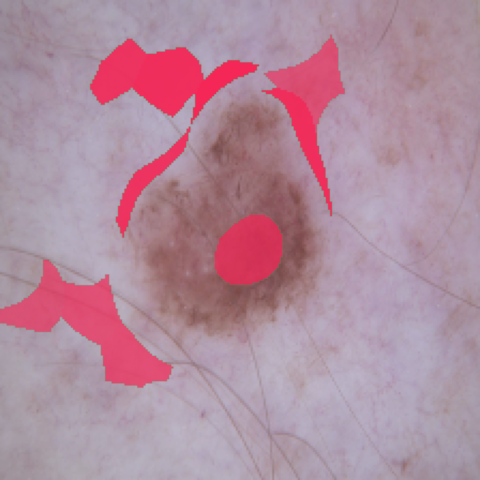

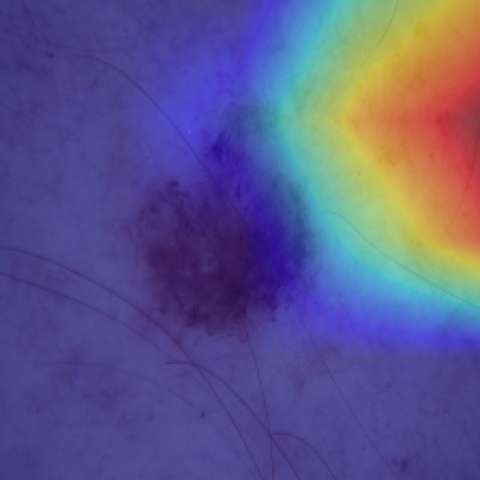

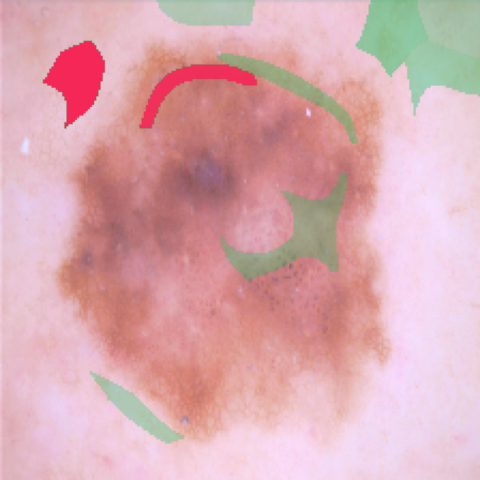

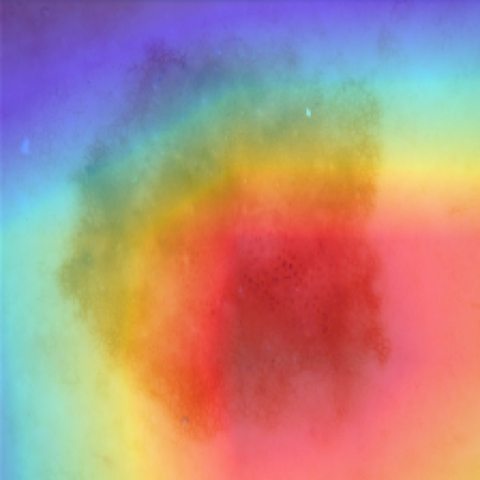

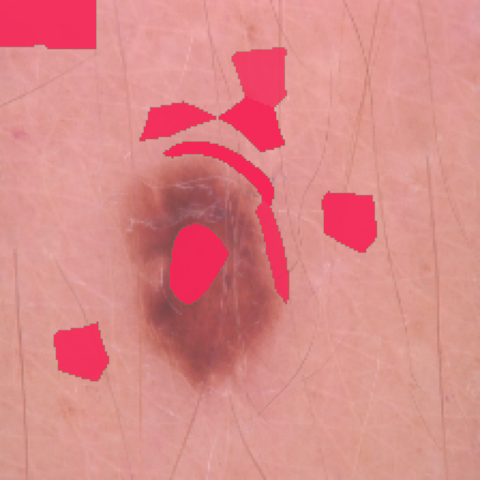

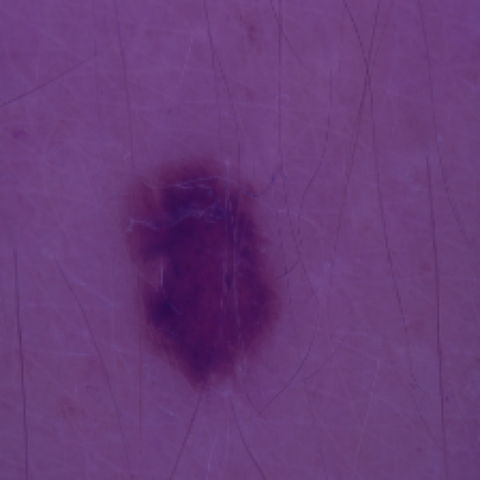

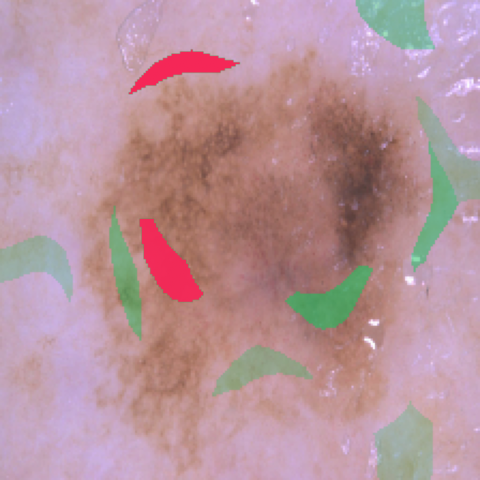

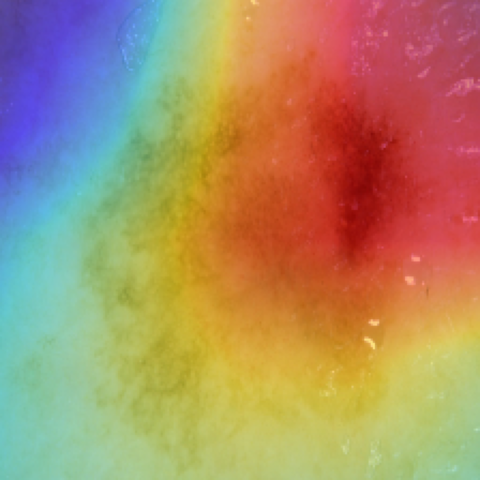

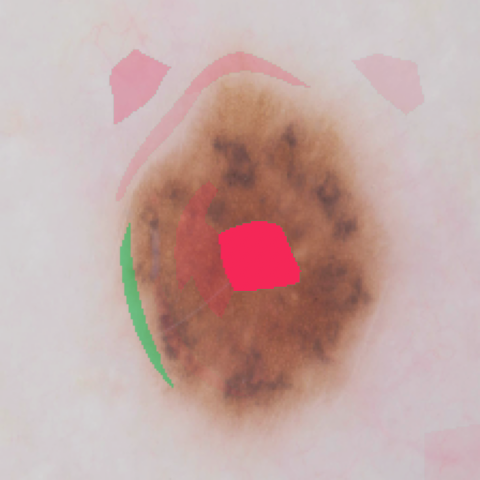

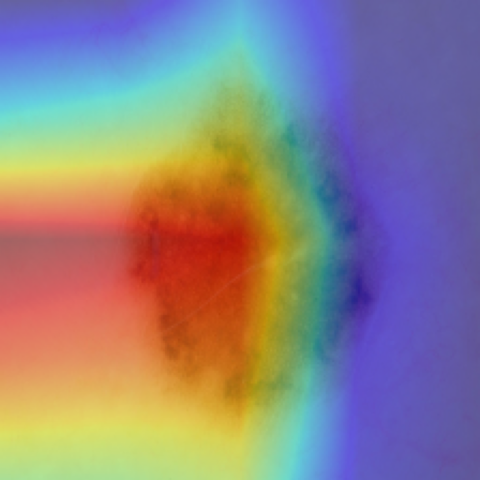

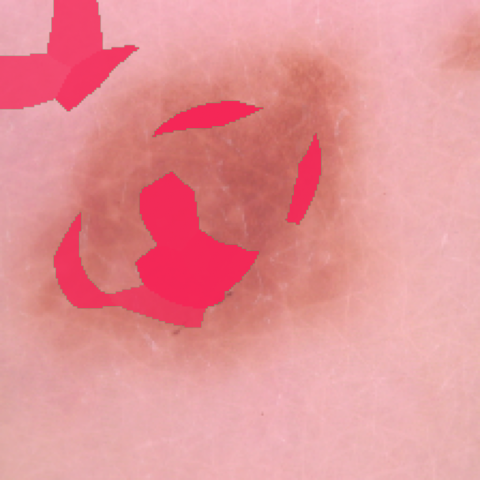

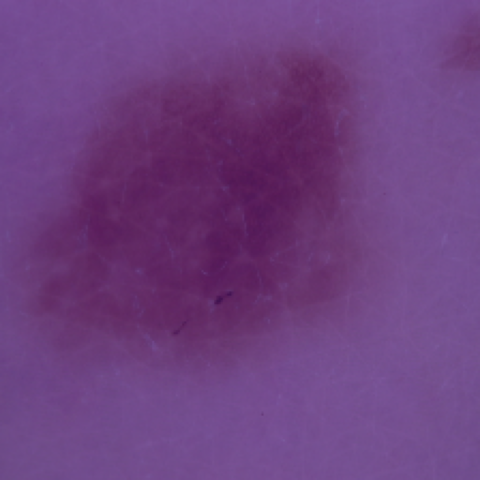

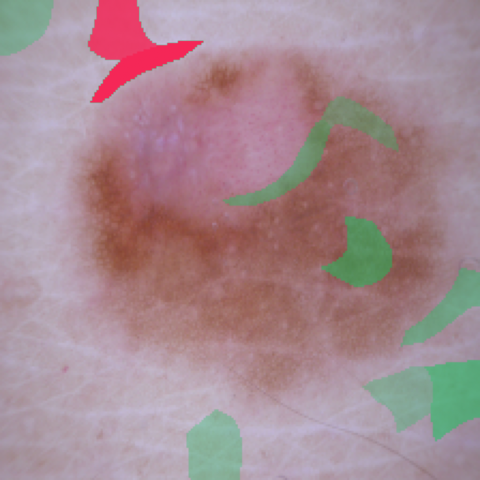

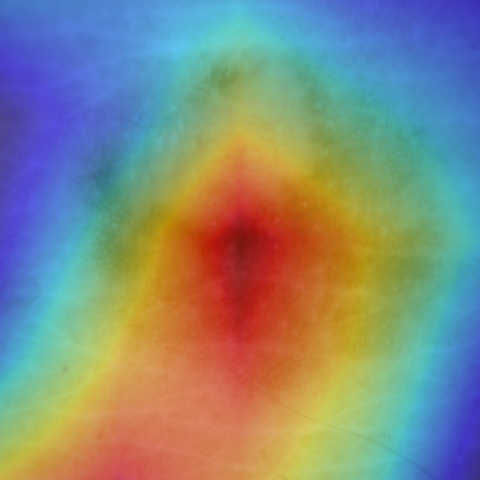

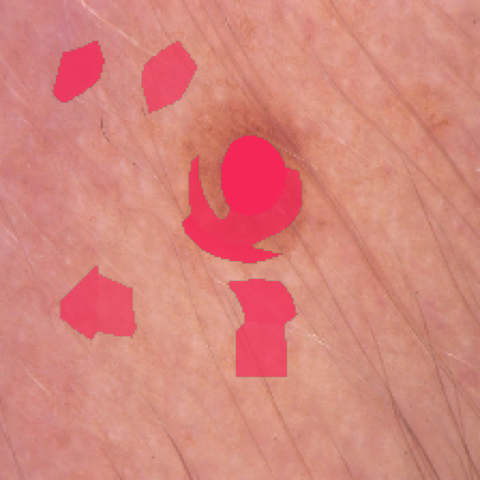

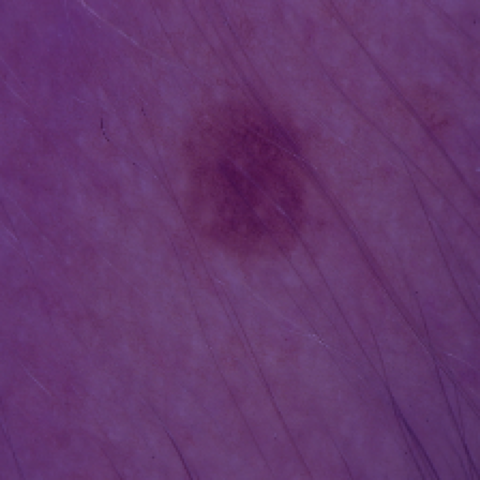

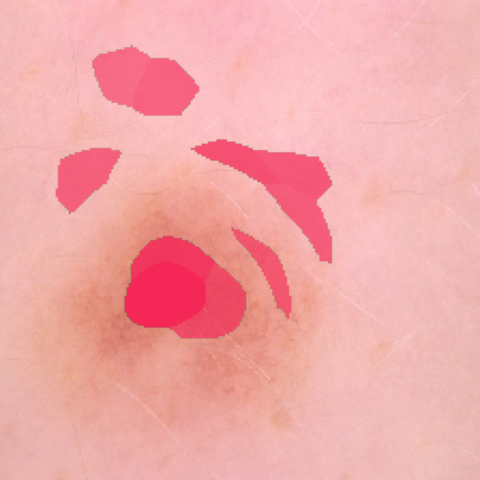

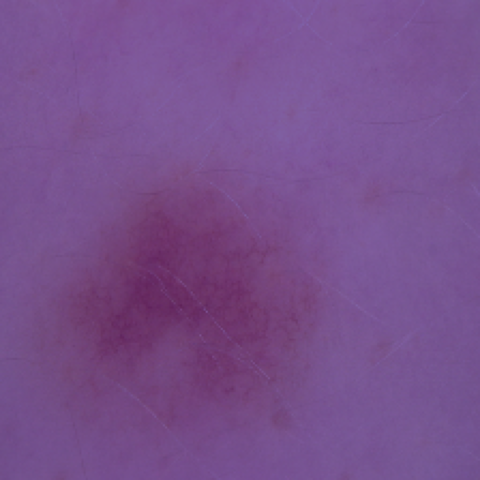

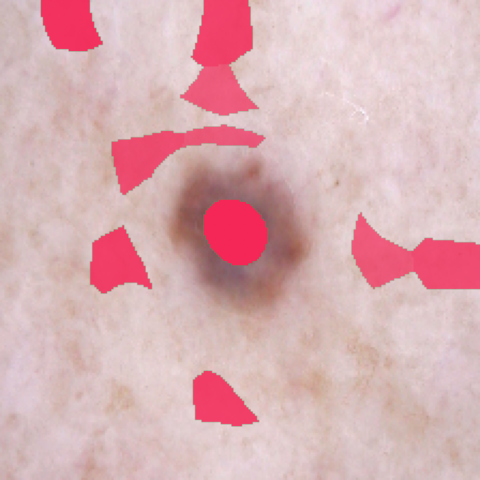

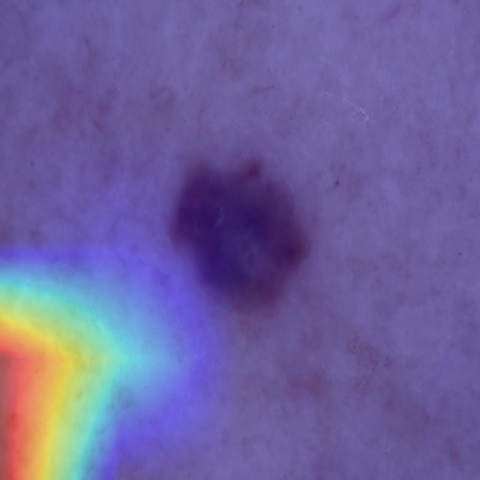

In [10]:

if not os.path.exists(f'Explanations_ModelSearch2_Seed_{seed}/'):
    os.mkdir(f'Explanations_ModelSearch2_Seed_{seed}/')

# Run the SHAP/GradCAM batch processing
batch_shap2(features, sample_images, model, gmodel, f'Explanations_ModelSearch2_Seed_{seed}/')

# Clean up memory
del(gmodel)